# Transfer Learning of ResNet-50
This jupyter notebook resolves the Kaggle Fruit 360 task using transfer learning. The network architecture is thereby adapted to later create class activation maps (more infos in my notebook "CMAP.ipynb"). The dataset contains enough images for training a CNN from scratch, but tranfer learning speeds up the learning progress to only take 5 epochs for a validation accuracy of 99 %. The retraining of the network was executed on a GPU in order to further reduce the overal computation time. 

## Dataset and Model
### Dataset
The used dataset can be found on Kaggel (https://www.kaggle.com/moltean/fruits). It's a dataset of 90483 images containing 131 different fruits and vegetables.

### Model
As model the pre-trained ResNet50 was downloaded from Keras and the last dense layers where dropped and a global average pooling layer was added. This is later used for creation of the class activation maps (c.f. CMAP.ipynb). Then, a dense layer with as many neurons as classes in the dataset was added (131 neurons). The model was trained and tested using the data from the Kaggle dataset and finally stored as "my_model.h5".

In [1]:
# necessary imports
import os
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import scipy

%matplotlib inline

In [2]:
# chek if cuda is set up -> if GPU is available, it works
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Reading data
Now the data shall be read in. The tensorflow ImageDataGenerator is used. This function will fetch the data and feed it to the network when requested. Advantage: It's not going to load and augment all data at once (which could consume a lot of memory), but one-by-one. This requires less memory, but more training time.

In [3]:
# create folder where the trained model can be stored later
path = os.getcwd()
model_path = os.path.join(path, 'Trained_Model')

if not os.path.exists(model_path):
    os.makedirs(model_path)

In [4]:
# set parameters of images such that they fit to ResNet-50 model which will be used for training (224, 224, 3)
img_width, img_height = 224, 224

train_data_dir = os.path.join(path, r'5857_1166105_bundle_archive\fruits-360\Training')
test_data_dir = os.path.join(path, r'5857_1166105_bundle_archive\fruits-360\Test')

batch_size = 16

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [6]:
def extract_labels(data_path):
    ''' this function returns a list of labels corresponding to the path provided '''
    return os.listdir(data_path)

def get_label(label_categorical, class_list):
    '''
    this fucntion returns the name of the label corresponding the the provided category 
    
    Inputs:
        1) : label_categorical (numpy array) : categorical array containing only a 1 for the selected label
        2) : class_list (list of strings) : list of strings containing the class names (extracted form the directory)
        
    Outputs:
        returns the string containing the correct class name
    '''
    # get index where label_categorical contains the 1
    index = np.where(label_categorical == 1)[0][0]
    # get label from class list using the index and return it
    return class_list[index]

Text(0.5, 1.0, 'Apple Braeburn')

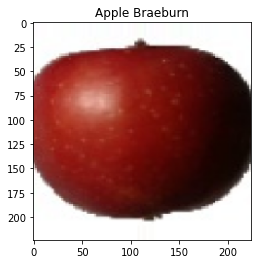

In [7]:
# print one example image and it's corresponding label from training set
batch_nr = 0
img_nr = np.random.choice(np.arange(0, batch_size))

# get list of class names
class_list = extract_labels(train_data_dir)

# get batch -> returns tuple (x, y) where x contains all the images of shape (batch_size, 224, 224, 3) and y contains the 
# corresonding labels of shape (batch_size, 131)
train_batch_tuple = train_generator[batch_nr]
train_batch_data = train_batch_tuple[0]
train_batch_label = train_batch_tuple[1]

# now: get label name
class_name = get_label(train_batch_label[img_nr], class_list)

# now: plot image and set title to corresponding label
img = train_batch_data[img_nr]
plt.imshow(img)
plt.title(class_name)

## Load and compile pretrained Model

In [8]:
# include_top false to not include the last fully connected layer
model_res50 = applications.ResNet50(weights='imagenet', include_top=False) 

In [9]:
# get netowrk architecture
model_res50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [10]:
# add a global spatial average pooling layer
x = model_res50.output
x = GlobalAveragePooling2D()(x)

# add a flatten layer
x = Flatten()(x)

# and a fully connected output/classification layer
predictions = Dense(131, activation='softmax')(x)

# create the full network so we can train on it
model_transfer = Model(inputs=model_res50.input, outputs=predictions)

In [11]:
# get new network architecture
model_transfer.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [12]:
# compile
model_transfer.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [13]:
# check locally avaiable devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14299571594018905499
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11429982234947012173
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6619702240
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7519949099189310648
physical_device_desc: "device: 0, name: Quadro P4000, pci bus id: 0000:04:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7716347548412892531
physical_device_desc: "device: XLA_GPU device"
]


In [14]:
with tf.device("/device:GPU:0"):
    history_pretrained = model_transfer.fit(
    train_generator,
    epochs=5, shuffle = True, verbose = 1, validation_data = test_generator)

Epoch 1/5
4231/4231 [==============================] - 3170s 749ms/step - loss: 0.9945 - accuracy: 0.8350 - val_loss: 0.0985 - val_accuracy: 0.9781
Epoch 2/5
4231/4231 [==============================] - 1451s 343ms/step - loss: 0.0809 - accuracy: 0.9925 - val_loss: 0.0543 - val_accuracy: 0.9864
Epoch 3/5
4231/4231 [==============================] - 1440s 340ms/step - loss: 0.0378 - accuracy: 0.9970 - val_loss: 0.0423 - val_accuracy: 0.9890
Epoch 4/5
4231/4231 [==============================] - 1418s 335ms/step - loss: 0.0243 - accuracy: 0.9983 - val_loss: 0.0393 - val_accuracy: 0.9888
Epoch 5/5
4231/4231 [==============================] - 1433s 339ms/step - loss: 0.0170 - accuracy: 0.9991 - val_loss: 0.0347 - val_accuracy: 0.9907


In [15]:
model_name = 'my_model.h5'
model_path_new = os.path.join(model_path, model_name)

In [16]:
# save full model for later reusage
model_transfer.save(model_path_new)
# load it later using "new_model = tf.keras.models.load_model(model_path_new)""

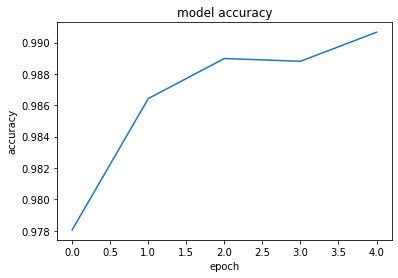

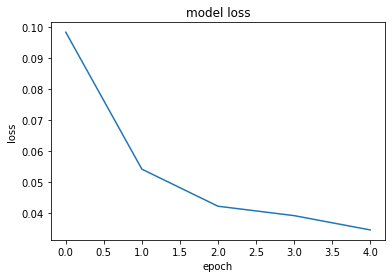

In [17]:
# summarize history for accuracy
plt.plot(history_pretrained.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# summarize history for loss
plt.plot(history_pretrained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()